# Predicting Loan Outcomes: Data Visualization
## CS109A
### Team members: Maryam Alireza, Hector Cordero, Regina Legarreta, Pranav Sidhwani

Import libraries

In [214]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import sklearn.preprocessing as Preprocessing
from sklearn.cross_validation import train_test_split
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
import plotly.plotly as py
from plotly.offline import plot
import plotly
import time
plotly.offline.init_notebook_mode()
%matplotlib inline
plt.style.use('ggplot')

Reading the dataset

In [161]:
# Reading the data as a pandas dataframe
df = pd.read_csv('Data/loan.csv', low_memory=False)

# Looking at the first 5 observations
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Overall book

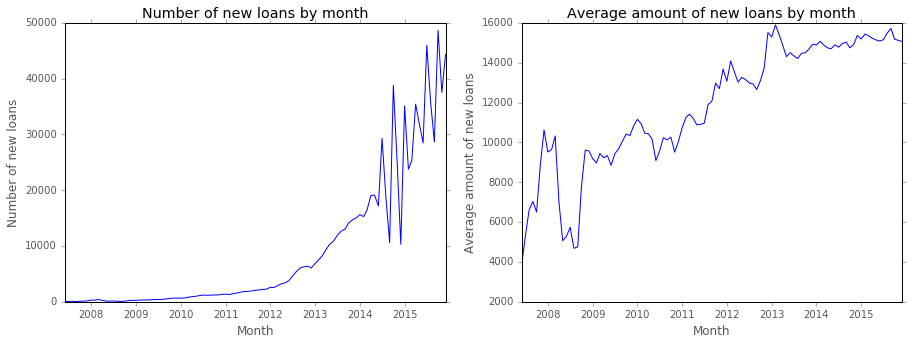

In [162]:
# Month variable: 
# The month in which the loan was funded: issue_d
# The total amount committed to that loan in that point of time: funded_amnt

# For new loans

# Plot: Number of new loans per month
freqnew = df.groupby(['issue_d'])['id'].count()
freqnew = freqnew.reset_index()

freqnew['date'] = ''
for i in range(freqnew.shape[0]):
    datestring = freqnew.loc[i, 'issue_d']
    freqnew.loc[i, 'date'] = datetime.strptime(datestring, '%b-%Y')

freqnew = freqnew.sort_values('date')
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax1.plot(freqnew['date'],freqnew['id'], 'b-')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of new loans')
ax1.set_title('Number of new loans by month')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

# Plot: Average amount of loans by month
avgnew = df.groupby(['issue_d'])['funded_amnt'].mean()

avgnew = avgnew.reset_index()

avgnew['date'] = ''
for i in range(avgnew.shape[0]):
    datestring = avgnew.loc[i, 'issue_d']
    avgnew.loc[i, 'date'] = datetime.strptime(datestring, '%b-%Y')

avgnew = avgnew.sort_values('date')
#fig = plt.figure()
ax2 = fig.add_subplot(122)
ax2.plot(avgnew['date'],avgnew['funded_amnt'], 'b-')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average amount of new loans')
ax2.set_title('Average amount of new loans by month')
ax2.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_color('k')

plt.show()

Keeping a copy of the full dataset

In [163]:
full_df = df

Selecting rows

In [164]:
df['issue_d']=df['issue_d'].apply(lambda x: datetime.strptime(x,'%b-%Y'))


# Keeping only inactive loans
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

df=df[df['issue_d']<=datetime(2012,12,31)]
df['default'] = df['loan_status'].isin(['Charged Off', 'Default'])

In [165]:
df = df.reset_index()
df['num'] = 1
df['default2'] = 0
for i in range(df.shape[0]):
    if df.loc[i, 'default'] == True:
        df.loc[i, 'default2'] = 1

Dealing with missing data

In [166]:
#We look at each column to judge if the number of missing values is too high and consequently drop
column_name=[]
length=[]
for column in df.columns:
    column_name.append(column)
    longi= 1 - len(df[column][df[column].isnull()]) / float(len(df['id']))
    length.append(longi)

In [167]:
df.mths_since_last_delinq.unique()

df.ix[df.mths_since_last_delinq.isnull(), 'mths_since_last_delinq'] = 9999

In [168]:
def replace_desc(x):
    if pd.isnull(x):
        return 0
    else:
        return 1

In [169]:
df['desc'] = df['desc'].map(replace_desc)

In [170]:
complete_cols = [column for column in df.columns if len(df[column][df[column].isnull()]) <= len(df[column])/3 ]
df = df[complete_cols]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,default,num,default2
0,0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,...,Jan-2015,171.62,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,False,1,0
1,1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,...,Apr-2013,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,True,1,1
2,2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,...,Jun-2014,649.91,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,False,1,0
3,3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,...,Jan-2015,357.48,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,False,1,0
4,5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,...,Jan-2015,161.03,Sep-2015,0.0,1.0,INDIVIDUAL,0.0,False,1,0


In [171]:
#We look at each column to judge if the number of missing values is too high and consequently drop
column_name=[]
length=[]
for column in df.columns:
    column_name.append(column)
    longi= 1 - len(df[column][df[column].isnull()]) / float(len(df['id']))
    length.append(longi)

In [172]:
def replace_missing(x):
    if pd.isnull(x):
        return 'missing'
    else:
        return x

In [173]:
df['emp_title'] = df['emp_title'].map(replace_missing)

Visualizations

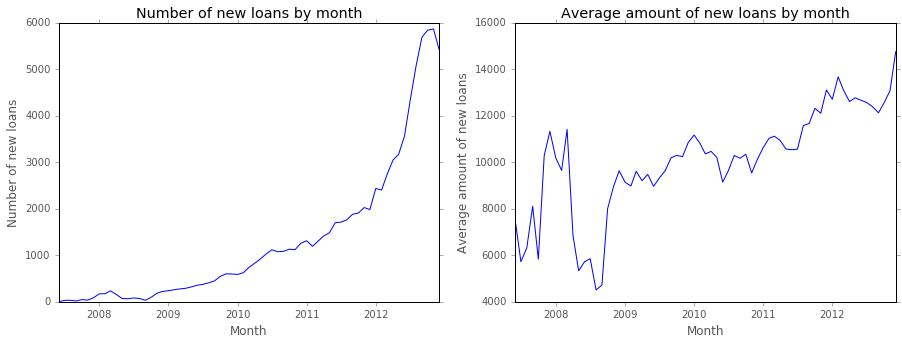

In [174]:
# Month variable: 
# The month in which the loan was funded: issue_d
# The total amount committed to that loan in that point of time: funded_amnt

# For new loans

# Plot: Number of new loans per month
freqnew = df.groupby(['issue_d'])['id'].count()
freqnew = freqnew.reset_index()


freqnew = freqnew.sort_values('issue_d')
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax1.plot(freqnew['issue_d'],freqnew['id'], 'b-')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of new loans')
ax1.set_title('Number of new loans by month')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

# Plot: Average amount of loans by month
avgnew = df.groupby(['issue_d'])['funded_amnt'].mean()

avgnew = avgnew.reset_index()

avgnew = avgnew.sort_values('issue_d')
#fig = plt.figure()
ax2 = fig.add_subplot(122)
ax2.plot(avgnew['issue_d'],avgnew['funded_amnt'], 'b-')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average amount of new loans')
ax2.set_title('Average amount of new loans by month')
ax2.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_color('k')

plt.show()

In [175]:

df['default'] = df['loan_status'].isin(['Charged Off', 'Default'])

print "Number of inactive loans: " + str(len(df)) + "\nNumber of defaulted or charged-off loans: " + str(len(df[df.default == 1])) 
default_rate = round(float(len(df[df.default == 1]))/len(df), 4)
print "Default rate: " + str(default_rate)

df['default'].describe()

Number of inactive loans: 87325
Number of defaulted or charged-off loans: 13695
Default rate: 0.1568


count     87325
unique        2
top       False
freq      73630
Name: default, dtype: object

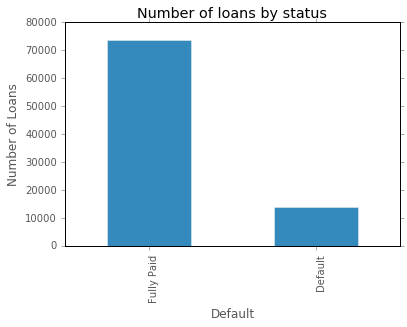

In [176]:
# Total number of loans by status

fig = plt.figure()
ax1 = fig.add_subplot(111)
df.groupby(['default'])['id'].count().plot(kind='bar', ax=ax1, color = plt.rcParams['axes.color_cycle'][1])
labels = ['Fully Paid', 'Default']
ax1.set_xticklabels(labels, rotation=90, ha='right',rotation_mode='anchor')
ax1.set_title('Number of loans by status')
ax1.set_xlabel('Default')
ax1.set_ylabel('Number of Loans')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

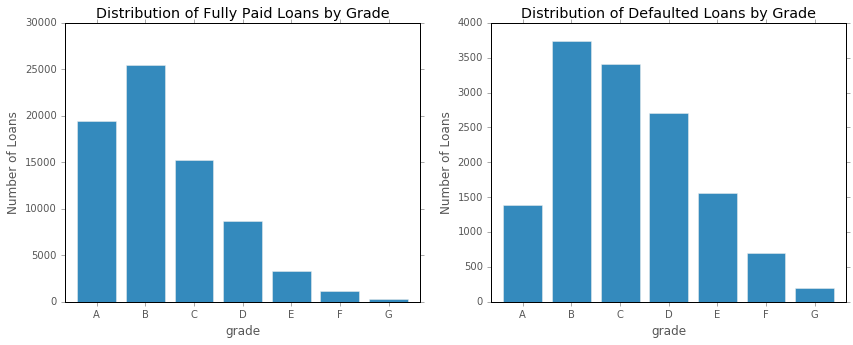

In [177]:
# 2. Total number of loans by status and grade

fig2 = plt.figure(figsize=(14,5))
ax1 = fig2.add_subplot(121)
#fig2.canvas.draw()
df[df['default']==0].groupby(['grade'])['id'].count().plot(kind='bar', ax=ax1,width=0.8, color = plt.rcParams['axes.color_cycle'][1])
ax1.set_xticklabels(ax1.get_xticklabels(),ha='center',rotation=360)
ax1.set_title("Distribution of Fully Paid Loans by Grade")
ax1.set_ylabel('Number of Loans')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

ax2 = fig2.add_subplot(122)
#fig2.canvas.draw()
df[df['default']==1].groupby(['grade'])['id'].count().plot(kind='bar', ax=ax2,width=0.8, color = plt.rcParams['axes.color_cycle'][1])
ax2.set_xticklabels(ax2.get_xticklabels(),ha='center',rotation=360)
ax2.set_title("Distribution of Defaulted Loans by Grade")
ax2.set_ylabel('Number of Loans')
ax2.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_color('k')
plt.show()

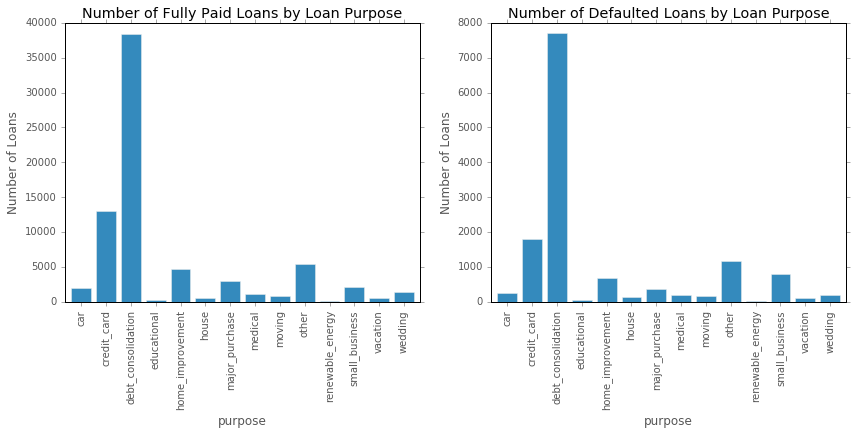

In [178]:
fig1 = plt.figure(figsize=(14,5))

ax1 = fig1.add_subplot(121)
#fig2.canvas.draw()
labels = [item.get_text() for item in ax1.get_xticklabels()]
#labels = purpose_non['purpose']
df[df['default']==0].groupby(['purpose'])['id'].count().plot(kind='bar', ax=ax1,width=0.8, color = plt.rcParams['axes.color_cycle'][1])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90,ha='center')
ax1.set_title("Number of Fully Paid Loans by Loan Purpose")
ax1.set_ylabel('Number of Loans')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

ax2 = fig1.add_subplot(122)
#fig2.canvas.draw()
labels = [item.get_text() for item in ax2.get_xticklabels()]
#labels = purpose_non['purpose']
df[df['default']==1].groupby(['purpose'])['id'].count().plot(kind='bar', ax=ax2,width=0.8, color = plt.rcParams['axes.color_cycle'][1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90,ha='center')
ax2.set_title("Number of Defaulted Loans by Loan Purpose")
ax2.set_ylabel('Number of Loans')
#ax2.set_ylim((0,40000)) #maybe take this out?
ax2.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_color('k')
plt.show()

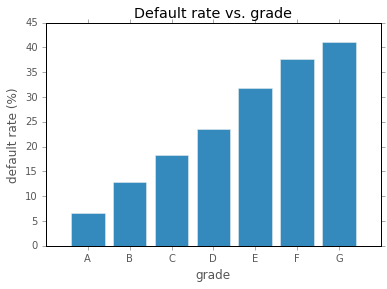

In [179]:
#Default rate by grade
grade = df.groupby(['grade'])['num', 'default2'].sum()
grade['default_rate'] = grade['default2']/grade['num']
grade = grade.reset_index()
LABELS = ['A','B','C','D','E','F','G']
LABELS = grade['grade']
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(range(grade.shape[0]), grade['default_rate']*100,align='center')
plt.xticks(range(grade.shape[0]), LABELS, ha='center')
ax1.set_xlabel('grade')
ax1.set_ylabel('default rate (%)')
ax1.set_title('Default rate vs. grade')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

plt.show()

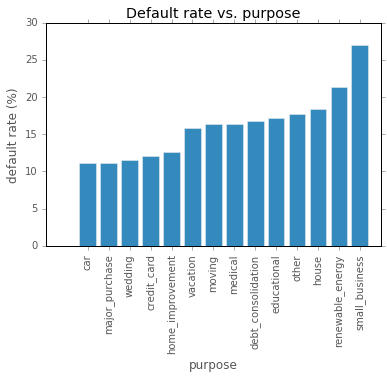

In [180]:
purpose = df.groupby(['purpose'])['num', 'default2'].sum()
purpose['default_rate'] = purpose['default2']/purpose['num']
purpose = purpose.reset_index()
purpose=purpose.sort_values(by=['default_rate'], ascending=True)
LABELS=purpose['purpose']

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(range(purpose.shape[0]), purpose['default_rate']*100,align='center')
plt.xticks(range(purpose.shape[0]), LABELS, rotation=90,ha='center')
ax1.set_xlabel('purpose')
ax1.set_ylabel('default rate (%)')
ax1.set_title('Default rate vs. purpose')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

plt.show()

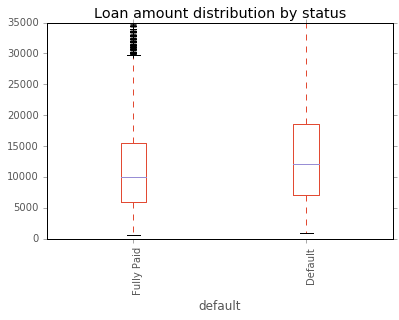

In [181]:
fig = plt.figure()
ax = fig.add_subplot(111)
#labels = df['loan_status'].unique()
df.boxplot(ax=ax,column='loan_amnt', by='default')
labels = ['Fully Paid', 'Default']
ax.set_xticklabels(labels, rotation=90, ha='right',rotation_mode='anchor')
fig.suptitle('')
ax.set_title('Loan amount distribution by status')
ax.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')

plt.show()

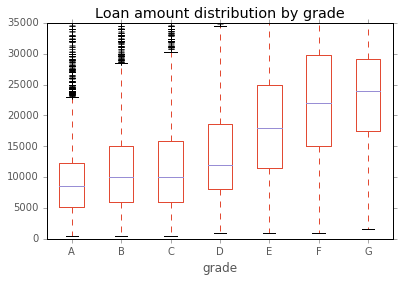

In [182]:
#dfg=df[df['grade']=='G']
#print dfg['loan_amnt'].mean()
fig = plt.figure()
ax = fig.add_subplot(111)
df.boxplot(ax=ax,column='loan_amnt', by='grade')
labels = ax.get_xticklabels()
ax.set_xticklabels(labels,ha='center')
fig.suptitle('')
ax.set_title('Loan amount distribution by grade')
ax.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')
plt.show()

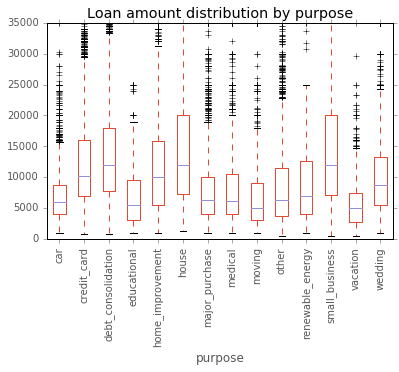

In [183]:
#dfg=df[df['grade']=='G']
#print dfg['loan_amnt'].mean()
fig = plt.figure()
ax = fig.add_subplot(111)
df.boxplot(ax=ax,column='loan_amnt', by='purpose')
labels = ax.get_xticklabels()
fig.suptitle('')
ax.set_xticklabels(labels,rotation=90,ha='center')
ax.set_title('Loan amount distribution by purpose')
ax.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')
plt.show()

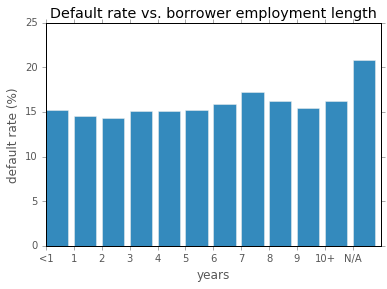

In [184]:
# Demographic

###******PRANAV WILL CHANGE IT TO EMPLOYMENT RATE VS. DEFAULT RATE

# 1. Length of employment
# a. Count
emp = df.groupby(['emp_length'])['num', 'default2'].sum()
emp['default_rate'] = emp['default2']/emp['num']
emp = emp.reset_index()
emp = emp.reindex([10, 0, 2, 3, 4, 5, 6, 7, 8, 9, 1, 11])
LABELS = ['<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+', 'N/A']
#LABELS = emp['emp_length']

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(range(emp.shape[0]), emp['default_rate']*100)
plt.xticks(range(emp.shape[0]), LABELS, ha='center')
ax1.set_xlabel('years')
ax1.set_ylabel('default rate (%)')
ax1.set_title('Default rate vs. borrower employment length')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')
plt.show()

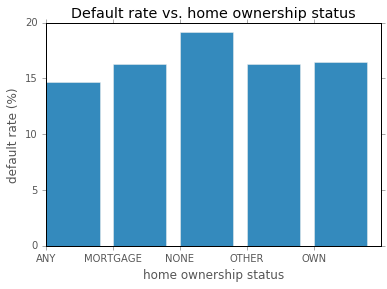

In [185]:
# 2. Home ownership
###******PRANAV WILL CHANGE IT TO HO VS. DEFAULT RATE
# a. Count
ho = df.groupby(['home_ownership'])['num', 'default2'].sum()
ho['default_rate'] = ho['default2']/ho['num']
ho = ho.reset_index()
LABELS = ['ANY', 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT']

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(range(ho.shape[0]), ho['default_rate']*100)
plt.xticks(range(ho.shape[0]), LABELS, ha='center')
ax1.set_xlabel('home ownership status')
ax1.set_ylabel('default rate (%)')
ax1.set_title('Default rate vs. home ownership status')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')
plt.show()

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 9 Text xticklabel objects>)

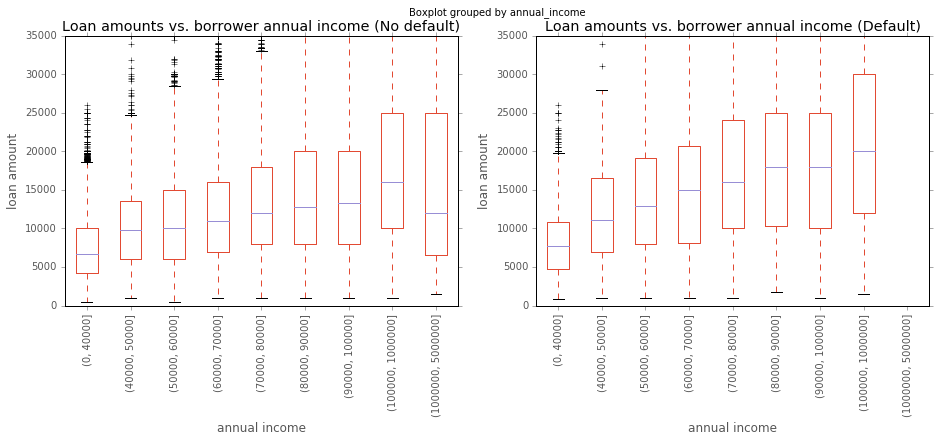

In [186]:
# b. DEFAULT VS ANNUAL INCOME
# Creating new column with bins
filter_values = [0, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 1000000, 5000000]
df['annual_income'] = pd.cut(df.annual_inc, bins = filter_values)
###PRANAV GRAPH ANNUAL INCOME VS DEFAULT....
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
df_nodef = df[df['default2'] == 0]
df_nodef.boxplot(ax = ax, column='loan_amnt', by='annual_income')
ax.set_xlabel('annual income')
ax.set_ylabel('loan amount')
ax.set_title('Loan amounts vs. borrower annual income (No default)')
ax.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')
plt.xticks(rotation=90,ha='center')

df_def = df[df['default2'] == 1]
ax1 = fig.add_subplot(122)
df_def.boxplot(ax = ax1, column='loan_amnt', by='annual_income')
ax1.set_xlabel('annual income')
ax1.set_ylabel('loan amount')
ax1.set_title('Loan amounts vs. borrower annual income (Default)')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')
plt.xticks(rotation=90,ha='center')

In [187]:
state = df.groupby(['addr_state'])['num', 'default2'].sum()
state['default_rate'] = (state['default2']/state['num'])*100
state['default_rate'] = np.round(state['default_rate'], 2)
state = state.reset_index()

In [188]:
for col in state.columns:
    state[col] = state[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

state['text'] = state['addr_state'] + '<br>' +\
    'Default Rate '+ state['default_rate'] + '%'

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state['addr_state'],
        z = state['default_rate'].astype(float),
        locationmode = 'USA-states',
        text = state['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Percentage")
        ) ]

layout = dict(
        title = 'Loan Default Rate by State (%)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
#plotly.offline.iplot( fig, filename='d3-cloropleth-map' )
plotly.offline.iplot( fig, filename='d3-cloropleth-map' )

#### Computing and validating correlations between loan status and indicators like FICO score, credit score and other personal history in order to model interactions.

- Debt to income
- Risk score
- Delinq_2y
- Revol_bal
- Grade
- inq_last_6mths

In [189]:
labels  = ['No default', 'Default']

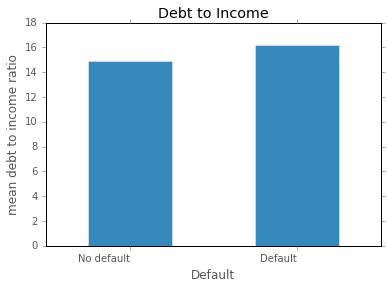

Debt to income
count    87325.000000
mean        15.118501
std          7.385465
min          0.000000
25%          9.570000
50%         14.980000
75%         20.450000
max         34.990000
Name: dti, dtype: float64

 Paid
count    73630.000000
mean        14.917337
std          7.362307
min          0.000000
25%          9.370000
50%         14.750000
75%         20.220000
max         34.990000
Name: dti, dtype: float64

 Defaulted
count    13695.000000
mean        16.200042
std          7.416062
min          0.000000
25%         10.770000
50%         16.330000
75%         21.480000
max         34.950000
Name: dti, dtype: float64


In [190]:
# Debt to income (dti)

fig = plt.figure()
ax = fig.add_subplot(111)
df.groupby(['default'])['dti'].mean().plot(kind='bar', ax=ax, color = plt.rcParams['axes.color_cycle'][1])
ax.set_xlabel('Default')
ax.set_ylabel('mean debt to income ratio')
ax.set_title('Debt to Income')
ax.set_axis_bgcolor('white')
ax.set_xticklabels(labels, rotation=0, ha='right',rotation_mode='anchor')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')


plt.show()

print "Debt to income"
print df['dti'].describe()

print "\n Paid"
print df[df.default == 0]['dti'].describe()

print "\n Defaulted"
print df[df.default == 1]['dti'].describe()

[  0.   2.   3.   1.   4.   6.   5.   8.   7.   9.  11.  13.  14.  12.  10.
  18.]


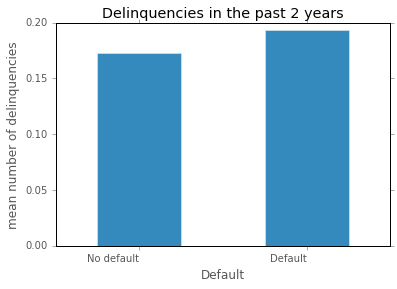

Delinquencies in the past 2 years
count    87325.000000
mean         0.176227
std          0.576904
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: delinq_2yrs, dtype: float64

 Paid
count    73630.000000
mean         0.173041
std          0.569836
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: delinq_2yrs, dtype: float64

 Defaulted
count    13695.000000
mean         0.193355
std          0.613251
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         14.000000
Name: delinq_2yrs, dtype: float64


In [191]:
# Delinquencies in the past 2 years

print df['delinq_2yrs'].unique()

fig = plt.figure()
ax = fig.add_subplot(111)
df.groupby(['default'])['delinq_2yrs'].mean().plot(kind='bar', ax=ax, color = plt.rcParams['axes.color_cycle'][1])
ax.set_xlabel('Default')
ax.set_ylabel('mean number of delinquencies')
ax.set_title('Delinquencies in the past 2 years')
ax.set_axis_bgcolor('white')
ax.set_xticklabels(labels, rotation=0, ha='right',rotation_mode='anchor')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')


plt.show()

print "Delinquencies in the past 2 years"
print df['delinq_2yrs'].describe()

print "\n Paid"
print df[df.default == 0]['delinq_2yrs'].describe()

print "\n Defaulted"
print df[df.default == 1]['delinq_2yrs'].describe()

# Notes: Are NaNs same as zeroes?

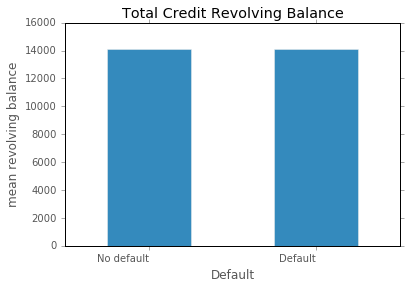

Total credit revolving balance
count     87325.000000
mean      14106.008085
std       15132.049279
min           0.000000
25%        5261.000000
50%       10431.000000
75%       18211.000000
max      975800.000000
Name: revol_bal, dtype: float64

 Total credit revolving balance if positive
count     86123.000000
mean      14302.882575
std       15144.598246
min           1.000000
25%        5452.000000
50%       10596.000000
75%       18378.500000
max      975800.000000
Name: revol_bal, dtype: float64

 Paid
count     73630.000000
mean      14101.146557
std       15310.355590
min           0.000000
25%        5193.000000
50%       10363.500000
75%       18196.000000
max      975800.000000
Name: revol_bal, dtype: float64

 Defaulted
count     13695.000000
mean      14132.145674
std       14135.399542
min           0.000000
25%        5626.500000
50%       10818.000000
75%       18292.500000
max      451481.000000
Name: revol_bal, dtype: float64


In [192]:
# Total credit revolving balance

fig = plt.figure()
ax = fig.add_subplot(111)
df.groupby(['default'])['revol_bal'].mean().plot(kind='bar', ax=ax, color = plt.rcParams['axes.color_cycle'][1])
ax.set_xlabel('Default')
ax.set_ylabel('mean revolving balance')
ax.set_title('Total Credit Revolving Balance')
ax.set_xticklabels(labels, rotation=0, ha='right',rotation_mode='anchor')
ax.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')

plt.show()

print "Total credit revolving balance"
print df['revol_bal'].describe()

print "\n Total credit revolving balance if positive"
print df[df.revol_bal > 0]['revol_bal'].describe()

print "\n Paid"
print df[df.default == 0]['revol_bal'].describe()

print "\n Defaulted"
print df[df.default == 1]['revol_bal'].describe()

['B' 'C' 'A' 'E' 'F' 'D' 'G']


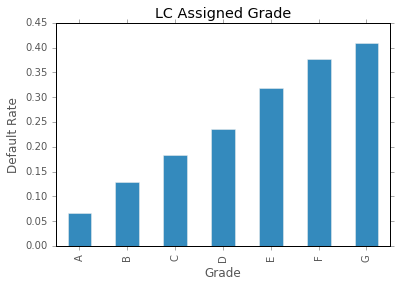

count     87325
unique        7
top           B
freq      29156
Name: grade, dtype: object

In [193]:
# Grade

print df['grade'].unique()

fig = plt.figure()
ax = fig.add_subplot(111)
df.groupby(['grade'])['default'].mean().plot(kind='bar', ax=ax, color = plt.rcParams['axes.color_cycle'][1])
ax.set_xlabel('Grade')
ax.set_ylabel('Default Rate')
ax.set_title('LC Assigned Grade')
ax.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')
plt.show()

df['grade'].describe()

[ 1.  5.  2.  3.  0.  4.  6.  7.  8.]


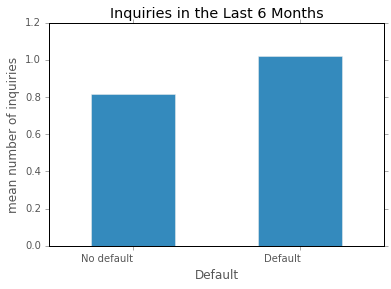

Number of inquiries in the past 6 months
count    87325.000000
mean         0.848176
std          1.037594
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64

 Paid
count    73630.000000
mean         0.816474
std          1.021699
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64

 Defaulted
count    13695.000000
mean         1.018620
std          1.103728
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: inq_last_6mths, dtype: float64


In [194]:
# Number of inquiries in the past 6 months

print df['inq_last_6mths'].unique()

fig = plt.figure()
ax = fig.add_subplot(111)
df.groupby(['default'])['inq_last_6mths'].mean().plot(kind='bar', ax=ax, color = plt.rcParams['axes.color_cycle'][1])
ax.set_xlabel('Default')
ax.set_ylabel('mean number of inquiries')
ax.set_title('Inquiries in the Last 6 Months')
ax.set_xticklabels(labels, rotation=0, ha='right',rotation_mode='anchor')
ax.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')

plt.show()

df['inq_last_6mths'].describe()

print "Number of inquiries in the past 6 months"
print df['inq_last_6mths'].describe()

print "\n Paid"
print df[df.default == 0]['inq_last_6mths'].describe()

print "\n Defaulted"
print df[df.default == 1]['inq_last_6mths'].describe()

# Notes: What to do with NaNs?

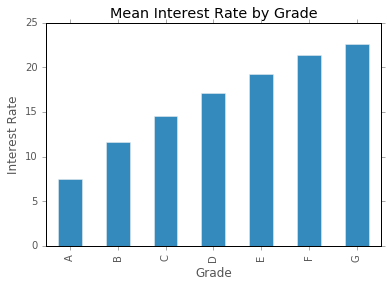

count    87325.000000
mean        12.710704
std          4.080138
min          5.420000
25%          9.760000
50%         12.610000
75%         15.310000
max         24.890000
Name: int_rate, dtype: float64

In [195]:
# Interest rates vs. loan grades

fig = plt.figure()
ax = fig.add_subplot(111)
df.groupby(['grade'])['int_rate'].mean().plot(kind='bar', ax=ax, color = plt.rcParams['axes.color_cycle'][1])
ax.set_xlabel('Grade')
ax.set_ylabel('Interest Rate')
ax.set_title('Mean Interest Rate by Grade')
ax.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_color('k')
plt.show()

df['int_rate'].describe()

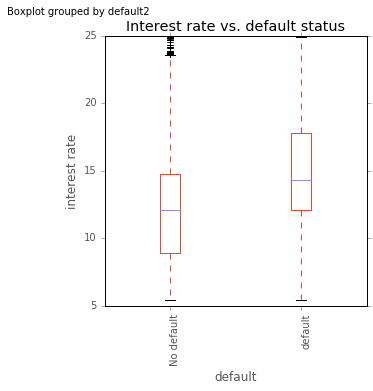

In [196]:
# Interest rates by grade
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(122)
df.boxplot(ax = ax1, column='int_rate', by='default2')
ax1.set_xlabel('default')
ax1.set_ylabel('interest rate')
ax1.set_title('Interest rate vs. default status')
ax1.set_axis_bgcolor('white')
labels = ['No default', 'default']
ax1.set_xticklabels(labels, rotation=90, ha='right',rotation_mode='anchor')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

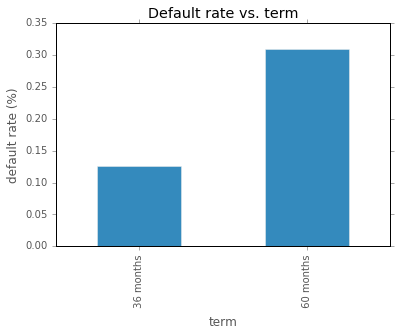

In [197]:
# Default rate by term
term = df.groupby(['term'])['num', 'default2'].sum()
term['default_rate'] = term['default2']/term['num']
term = term.reset_index()
LABELS = term['term']
fig = plt.figure()
ax1 = fig.add_subplot(111)
df.groupby(['term'])['default2'].mean().plot(kind='bar', color = plt.rcParams['axes.color_cycle'][1], ax=ax1)
plt.xticks(range(term.shape[0]), LABELS, ha='center')
ax1.set_xlabel('term')
ax1.set_ylabel('default rate (%)')
ax1.set_title('Default rate vs. term')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

plt.show()

Looking at default rate by year for the full dataset

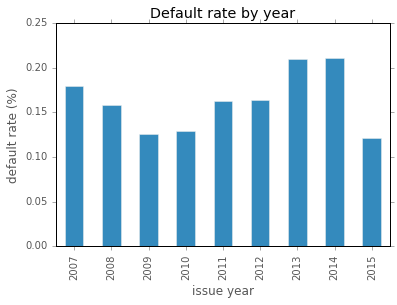

In [243]:
# Subset full_df to keep only inactive loans
full_df = full_df[full_df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

# Getting default variable
full_df['default'] = full_df['loan_status'].isin(['Charged Off', 'Default'])

# Getting a column of ones
full_df['num'] = 1

# Getting the year in another column
full_df['issue_yr'] = full_df['issue_d'].dt.year
full_df['issue_qr'] = full_df['issue_d'].dt.quarter

# Plotting default by year
fig = plt.figure()
ax1 = fig.add_subplot(111)
full_df.groupby(['issue_yr'])['default'].mean().plot(kind='bar', ax=ax1, color = plt.rcParams['axes.color_cycle'][1])
ax1.set_xlabel('issue year')
ax1.set_ylabel('default rate (%)')
ax1.set_title('Default rate by year')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

plt.show()